In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from triplet_preparation import inputs_from_tuples, tuples_from_file_array, train_inputs_file_array_generator, train_inputs_length
from model_architecture import triplet_network_model

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tf.__version__, tf.keras.__version__

('2.1.0', '2.2.4-tf')

In [3]:
'''Initialize triplet network for training'''
input_shape = (773,)
embedding_size = 10
model = triplet_network_model(input_shape, embedding_size, hidden_layers=[512,256,64])

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_0 (Dense)    (None, 512)               396288    
_________________________________________________________________
embedding_layer_1 (Dense)    (None, 256)               131328    
_________________________________________________________________
embedding_layer_3 (Dense)    (None, 10)                2570      
Total params: 530,186
Trainable params: 530,186
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 773)]        0                                            
_______________________________________________________________

In [6]:
class SkMetrics(keras.callbacks.Callback):
    def __init__(self, valid_data, steps_per_callback=10):
        super(SkMetrics, self).__init__()
        self.valid_data = valid_data
        self.steps_per_callback = steps_per_callback

    def on_train_begin(self, logs={}):
        self.test = []
        self.diagnostics = []

    def on_epoch_end(self, epoch, logs={}):
        #score = np.asarray(self.model.predict(self.valid_data[0]))
        #predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        #targ = self.validation_data[1]
        print("on_epoch_end")
        self.test.append(len(next(self.valid_data)))
        for i in range(self.steps_per_callback):
            self.diagnostics.append(f"entering for loop i={i}")
            anc, pos, neg = next(self.valid_data)
            self.diagnostics.append(f"sucessfully split training data")
            #predictions = self.model.predict([anc, pos, neg])
            #self.diagnostics.append(f"got embeddings")
            #self.test.append(predictions)
        return 1.0

samples_generator = train_inputs_file_array_generator(
    [os.path.abspath('../data/samples/lichess_db_standard_rated_2013-01-tuples.h5')],
    table_id_prefix="tuples",
    tuple_indices=[0,1,2,3,4,5,6],
    batch_size=16
)

skmetrics = SkMetrics(samples_generator, steps_per_callback=10)

In [7]:
# input arguments
train_files = [
	#os.path.abspath('../data/samples/lichess_db_standard_rated_2020-02-06-tuples-strong.h5'),
	os.path.abspath('../data/samples/lichess_db_standard_rated_2013-02-tuples.h5')
]

validation_files = [
	os.path.abspath('../data/samples/lichess_db_standard_rated_2013-01-tuples.h5')
]

batch_size = 16
steps_per_epoch = 1000
yield_augmented = 1

train_len = train_inputs_length(train_files, table_id_prefix="tuples")
print(f"{train_len} training samples.")

# generators for trian and test data
train_generator = train_inputs_file_array_generator(train_files, table_id_prefix="tuples",
					tuple_indices=[0,1,2,3,4,5,6], batch_size=batch_size)
validation_generator = train_inputs_file_array_generator(validation_files, table_id_prefix="tuples",
					tuple_indices=[0,1,2,3,4,5,6], batch_size=batch_size)


# train model
history = model.fit(
	train_generator,
	steps_per_epoch=steps_per_epoch,
    epochs=int(yield_augmented*train_len/steps_per_epoch/batch_size),
	validation_data=validation_generator,
	validation_steps=50,
	callbacks=[skmetrics]
)


111264 training samples.
Train for 1000 steps, validate for 50 steps
Epoch 1/6
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6300 - val_loss: 0.6489
Epoch 2/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5934 - val_loss: 0.4889
Epoch 3/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.4381 - val_loss: 0.3913
Epoch 4/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3529 - val_loss: 0.3049
Epoch 5/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3000 - val_loss: 0.2267
Epoch 6/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2766 - val_loss: 0.1959



history dict: dict_keys(['loss', 'val_loss'])
[3, 3, 3, 3, 3, 3]
['entering for loop i=0', 'sucessfully split training data', 'entering for loop i=1', 'sucessfully split training data', 'entering for loop i=2', 'sucessfully split training data', 'entering for loop i=3', 'sucessfully split training data', 'entering for loop i=4', 'sucessfully split training data', 'entering for loop i=5', 'sucessfully split training data', 'entering for loop i=6', 'sucessfully split training data', 'entering for loop i=7', 'sucessfully split training data', 'entering for loop i=8', 'sucessfully split training data', 'entering for loop i=9', 'sucessfully split training data', 'entering for loop i=0', 'sucessfully split training data', 'entering for loop i=1', 'sucessfully split training data', 'entering for loop i=2', 'sucessfully split training data', 'entering for loop i=3', 'sucessfully split training data', 'entering for loop i=4', 'sucessfully split training data', 'entering for loop i=5', 'sucessf

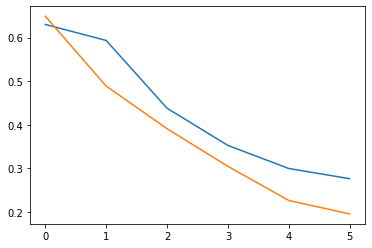

In [8]:
print('\nhistory dict:', history.history.keys())
print(skmetrics.test)
print(skmetrics.diagnostics)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(np.arange(len(loss)),loss)
plt.plot(np.arange(len(val_loss)),val_loss)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate([anc_test, pos_test, neg_test], batch_size=128)
print('test loss:', results)

### OLD

In [ ]:
'''Create Checkpoints during training'''

checkpoint_path = "checkpoints/test_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
history = model.fit(train_images, 
                    train_labels,  
                    epochs=10,
                    validation_data=(test_images,test_labels),
                    callbacks=[cp_callback])  # Pass callback to training


In [ ]:
'''Loads the weights from checkpoint path'''
model = create_model()
model.load_weights(checkpoint_path)

In [ ]:
'''Save the complete model after training'''
model.save('model/test_model', save_format='tf') # or save_format='h5'

In [ ]:
'''Load model from saved state'''
model = tf.keras.models.load_model('model/test_model')
model.summary()

In [ ]:
'''Use loaded model for inference'''
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))
print(model.predict(test_images).shape)